가스 종류별 arima 모델링 해서 단순 예측 해보기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/python/gas"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.1 MB/s 
     |████████████████████████████████| 9.8 MB 39.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install Bayesian-Optimization
!pip install catboost

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import plot_importance
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import random
import datetime
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [ ]:
gas = pd.read_csv(data_path + "/kgas.csv", encoding='cp949')
test = pd.read_csv(data_path + "/test.csv")
sub = pd.read_csv(data_path + "/sample_submission.csv")
temp = pd.read_csv(data_path + "/temperature.csv", encoding='cp949')

In [ ]:
gas.tail()

,연월일,시간,구분,공급량
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953
368087,2018-12-31,24,H,560.896


In [ ]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [ ]:
sub.tail()

,일자|시간|구분,공급량
15115,2019-03-31 20 H,0
15116,2019-03-31 21 H,0
15117,2019-03-31 22 H,0
15118,2019-03-31 23 H,0
15119,2019-03-31 24 H,0


In [ ]:
gas_t = temp[:2190]
gas_s_t = temp[2191:]

In [ ]:
gas_t.head()

,날짜,평균기온(℃),최저기온(℃),최고기온(℃)
0,2013-01-01,-3.2,-9.1,2.6
1,2013-01-02,-6.0,-11.2,0.0
2,2013-01-03,-9.9,-13.9,-5.1
3,2013-01-04,-9.0,-14.7,-1.9
4,2013-01-05,-5.9,-13.1,1.0


In [ ]:
gas['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [ ]:
# d_map = {}
# for i, d in enumerate(gas['구분'].unique()):
#     d_map[d] = i
# gas['구분'] = gas['구분'].map(d_map)

In [ ]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   period   368088 non-null  datetime64[ns]
 1   hour     368088 non-null  int64         
 2   class    368088 non-null  object        
 3   amount   368088 non-null  float64       
 4   year     368088 non-null  int64         
 5   month    368088 non-null  int64         
 6   day      368088 non-null  int64         
 7   weekday  368088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 22.5+ MB


In [ ]:
gas.head()

,period,hour,class,amount,year,month,day,weekday
0,2013-01-01,1,A,2497.129,2013,1,1,1
1,2013-01-01,2,A,2363.265,2013,1,1,1
2,2013-01-01,3,A,2258.505,2013,1,1,1
3,2013-01-01,4,A,2243.969,2013,1,1,1
4,2013-01-01,5,A,2344.105,2013,1,1,1


In [ ]:
gas['연월일'] = pd.to_datetime(gas['연월일'])
gas['year'] = gas['연월일'].dt.year
gas['month'] = gas['연월일'].dt.month
gas['day'] = gas['연월일'].dt.day
gas['weekday'] = gas['연월일'].dt.weekday
gas.rename(columns = {'시간' : 'hour', "구분": "class", "공급량": "amount", '연월일' : 'period'}, inplace = True)

In [ ]:
# 출력 행, 열 갯수 정하기
#pd.set_option('display.max_row', 1000)
#pd.set_option('display.max_columns', 100)
gas.sort_values(by=['year','month', 'day','hour','class'], ascending=True).iloc[0:20]

In [ ]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   hour     368088 non-null  int64  
 1   class    368088 non-null  object 
 2   amount   368088 non-null  float64
 3   year     368088 non-null  int64  
 4   month    368088 non-null  int64  
 5   day      368088 non-null  int64  
 6   weekday  368088 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 19.7+ MB


In [ ]:
gas['class'].value_counts()

D    52584
C    52584
E    52584
H    52584
A    52584
G    52584
B    52584
Name: class, dtype: int64

In [ ]:
print(gas.head())
print(gas.tail())

      period  hour class    amount  year  month  day  weekday
0 2013-01-01     1     A  2497.129  2013      1    1        1
1 2013-01-01     2     A  2363.265  2013      1    1        1
2 2013-01-01     3     A  2258.505  2013      1    1        1
3 2013-01-01     4     A  2243.969  2013      1    1        1
4 2013-01-01     5     A  2344.105  2013      1    1        1
           period  hour class   amount  year  month  day  weekday
368083 2018-12-31    20     H  681.033  2018     12   31        0
368084 2018-12-31    21     H  669.961  2018     12   31        0
368085 2018-12-31    22     H  657.941  2018     12   31        0
368086 2018-12-31    23     H  610.953  2018     12   31        0
368087 2018-12-31    24     H  560.896  2018     12   31        0


In [ ]:
plt.figure(figsize=(15,15))
for i, c in enumerate(gas['class'].unique()) :
  plt.subplot(3, 3, i+1)
  kk = gas[(gas['class'] == c)]
  plt.title(c)
  plt.plot(kk['period'], kk['amount'])

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(gas['period'].loc[gas['class'] == 'A'].loc[gas['period'] < '2013-01-05'], gas['amount'].loc[gas['class'] == 'A'].loc[gas['period'] < '2013-01-05'])

In [ ]:
for c in gas['class'].unique() :
  kk = gas[(gas['class'] == c)]
  print(kk[['period','class','amount']].loc[kk['amount'] == kk['amount'].max()])

         period class     amount
2230 2013-04-03     A  11593.617
          period class    amount
13723 2013-07-26     B  3798.613
           period class   amount
324884 2018-01-25     C  358.654
           period class    amount
333667 2018-01-26     D  2377.584
           period class    amount
342416 2018-01-26     E  5301.451
           period class     amount
112751 2014-11-14     G  10271.437
           period class    amount
237217 2016-01-24     H  6644.788


In [ ]:
#일별 사용량으로 변경
gas.rename(columns = {'시간' : 'hour', "구분": "class", "공급량": "amount", '연월일' : 'period'}, inplace = True)
#gas = gas.drop(['hour'],axis=1)
for i in gas['class'].unique() :
  globals()['gas_{}'.format(i)] = gas.loc[gas['class'] == i]

In [ ]:
gas_A

,period,class,amount
0,2013-01-01,A,2497.129
1,2013-01-01,A,2363.265
2,2013-01-01,A,2258.505
3,2013-01-01,A,2243.969
4,2013-01-01,A,2344.105
...,...,...,...
315523,2018-12-31,A,3040.868
315524,2018-12-31,A,2973.577
315525,2018-12-31,A,2840.272
315526,2018-12-31,A,2692.385


In [ ]:
gas_A = gas_A.groupby('period')['amount'].agg(**{'amount':'sum'}).reset_index()
gas_B = gas_B.groupby('period')['amount'].agg(**{'amount':'sum'}).reset_index()
gas_C = gas_C.groupby('period')['amount'].agg(**{'amount':'sum'}).reset_index()
gas_D = gas_D.groupby('period')['amount'].agg(**{'amount':'sum'}).reset_index()
gas_E = gas_E.groupby('period')['amount'].agg(**{'amount':'sum'}).reset_index()
gas_G = gas_G.groupby('period')['amount'].agg(**{'amount':'sum'}).reset_index()
gas_H = gas_H.groupby('period')['amount'].agg(**{'amount':'sum'}).reset_index()

In [ ]:
#gas_A.index = gas_A['period']
gas_A.set_index('period', inplace = True)

In [ ]:
gas_A.head()

,amount
period,
2013-01-01,60125.336
2013-01-02,74236.328
2013-01-03,79286.400
2013-01-04,78593.528
2013-01-05,69657.336


In [ ]:
gas_A.plot()

In [ ]:
#A
model_arima= auto_arima(gas_A.amount.values, trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3, suppress_warnings=True,stepwise=False,seasonal=False)


#model_arima.fit(gas_A.amount.values)

model_A = ARIMA(gas_A.amount.values, order=(3,0,2))
model_fit_A = model_A.fit(trend= 'c', ful_output = True, disp = True)
print(model_fit_A.summary())

fig = model_fit_A.plot_predict()
residuals = pd.DataFrame(model_fit_A.resid)
residuals.plot()

In [ ]:
#B
#model_arima= auto_arima(gas_B.amount.values, trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3, suppress_warnings=True,stepwise=False,seasonal=False)

#model_arima.fit(gas_B.amount.values)

model_B = ARIMA(gas_B.amount.values, order=(2,0,3))
model_fit_B = model_B.fit(trend= 'c', ful_output = True, disp = True)
print(model_fit_B.summary())

fig = model_fit_B.plot_predict()
residuals = pd.DataFrame(model_fit_B.resid)
residuals.plot()

In [ ]:
#C
#model_arima= auto_arima(gas_C.amount.values, trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3, suppress_warnings=True,stepwise=False,seasonal=False)

#model_arima.fit(gas_C.amount.values)

model_C = ARIMA(gas_C.amount.values, order=(2,0,2))
model_fit_C = model_C.fit(trend= 'c', ful_output = True, disp = True)
print(model_fit_C.summary())

fig = model_fit_C.plot_predict()
residuals = pd.DataFrame(model_fit_C.resid)
residuals.plot()

In [ ]:
#D
#model_arima= auto_arima(gas_D.amount.values, trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3, suppress_warnings=True,stepwise=False,seasonal=False)

#model_arima.fit(gas_D.amount.values)

model_D = ARIMA(gas_D.amount.values, order=(2,0,3))
model_fit_D = model_D.fit(trend= 'c', ful_output = True, disp = True)
print(model_fit_D.summary())

fig = model_fit_D.plot_predict()
residuals = pd.DataFrame(model_fit_D.resid)
residuals.plot()

In [ ]:
#E
#model_arima= auto_arima(gas_E.amount.values, trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3, suppress_warnings=True,stepwise=False,seasonal=False)

#model_arima.fit(gas_E.amount.values)

model_E = ARIMA(gas_E.amount.values, order=(2,0,3))
model_fit_E = model_E.fit(trend= 'c', ful_output = True, disp = True)
print(model_fit_E.summary())

fig = model_fit_E.plot_predict()
residuals = pd.DataFrame(model_fit_E.resid)
residuals.plot()

In [ ]:
#G
#model_arima= auto_arima(gas_G.amount.values, trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3, suppress_warnings=True,stepwise=False,seasonal=False)

#model_arima.fit(gas_G.amount.values)

model_G = ARIMA(gas_G.amount.values, order=(3,0,2))
model_fit_G = model_G.fit(trend= 'c', ful_output = True, disp = True)
print(model_fit_G.summary())

fig = model_fit_G.plot_predict()
residuals = pd.DataFrame(model_fit_G.resid)
residuals.plot()

In [ ]:
#H
#model_arima= auto_arima(gas_H.amount.values, trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3, suppress_warnings=True,stepwise=False,seasonal=False)

#model_arima.fit(gas_H.amount.values)

model_H = ARIMA(gas_H.amount.values, order=(3,0,1))
model_fit_H = model_H.fit(trend= 'c', ful_output = True, disp = True)
print(model_fit_H.summary())

fig = model_fit_H.plot_predict()
residuals = pd.DataFrame(model_fit_H.resid)
residuals.plot()

XGBoost

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import random
import datetime
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

In [ ]:
gas = pd.read_csv(data_path + "/kgas.csv", encoding='cp949')
test = pd.read_csv(data_path + "/test.csv")
sub = pd.read_csv(data_path + "/sample_submission.csv")

In [ ]:
gas.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [ ]:
te.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


xgboost에서는 datetime이 필요없으니까
연, 월, 일로 분리하고 datetime은 삭제하고
스캣폴드 하고 크로스 벨리데이션으로 돌리면 괜찮을거같은데
그러면 랜덤 추출해서 사용량을 y로 잡고 스캣폴드 한다음 검증하면 될듯

In [ ]:
gas['연월일'].str[8:11]

0         01
1         01
2         01
3         01
4         01
          ..
368083    31
368084    31
368085    31
368086    31
368087    31
Name: 연월일, Length: 368088, dtype: object

In [ ]:
gas['year'] = gas['연월일'].str[:4]
gas['month'] = gas['연월일'].str[5:7]
gas['day'] = gas['연월일'].str[8:11]
gas = gas.drop(['연월일'],axis = 1)
gas.rename(columns = {'시간' : 'hour', "구분": "class", "공급량": "amount"}, inplace = True)

In [ ]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   hour    368088 non-null  int64  
 1   class   368088 non-null  object 
 2   amount  368088 non-null  float64
 3   year    368088 non-null  object 
 4   month   368088 non-null  object 
 5   day     368088 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 16.8+ MB


이상치를 제거해주자

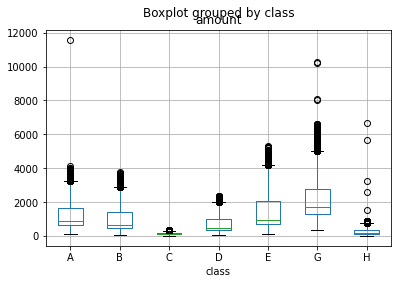

In [ ]:
gas.boxplot('amount', by = 'class')

A구분에 맥스값, G구분에 맥스값과 그다음 값, H구분에 맥스값과 그다음값 까지만 없애주자

In [ ]:
gas['amount'].groupby(by=gas['class']).max()

In [ ]:
gas.drop(gas.loc[gas['class'] == 'A'].loc[gas['amount'] > 10000].index, inplace = True)
gas.drop(gas.loc[gas['class'] == 'G'].loc[gas['amount'] > 7000].index, inplace = True)
gas.drop(gas.loc[gas['class'] == 'H'].loc[gas['amount'] > 4000].index, inplace = True)

In [ ]:
enc = LabelEncoder()
gas['class'] = enc.fit_transform(gas['class'])
gas['year'] = pd.to_numeric(gas['year'])
gas['month'] = pd.to_numeric(gas['month'])
gas['day'] = pd.to_numeric(gas['day'])

랜덤 추출해서 train test 셋 분리하고
모델 만들기

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
folds=[]
for train_idx, valid_idx in skf.split(gas, gas['amount']):
    folds.append((train_idx, valid_idx))

ValueError: ignored

In [ ]:
xtr, xte, ytr, yte = train_test_split(gas.drop(['amount'],axis=1), gas['amount'], test_size=0.2, random_state = 30)

In [ ]:
xte.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73617 entries, 348031 to 193308
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   hour    73617 non-null  int64
 1   class   73617 non-null  int64
 2   year    73617 non-null  int64
 3   month   73617 non-null  int64
 4   day     73617 non-null  int64
dtypes: int64(5)
memory usage: 3.4 MB


In [ ]:
ytr.head()

In [ ]:
xgb = XGBRegressor(n_estimators=5000, learning_rate=0.1, max_depth=7)
xgb_model = xgb.fit(xtr, ytr, early_stopping_rounds=500,eval_set=[(xte, yte)], verbose=500)

[04:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1196.41
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:107.908
[1000]	validation_0-rmse:93.1965
[1500]	validation_0-rmse:85.3804
[2000]	validation_0-rmse:80.4838
[2500]	validation_0-rmse:76.7688
[3000]	validation_0-rmse:73.7238
[3500]	validation_0-rmse:71.2876
[4000]	validation_0-rmse:69.1955
[4500]	validation_0-rmse:67.5662
[4999]	validation_0-rmse:66.1188


In [ ]:
test = pd.read_csv(data_path + "/test.csv")

In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['year'] = test['일자'].str[:4]
test['month'] = test['일자'].str[5:7]
test['day'] = test['일자'].str[8:11]
test.rename(columns = {'시간' : 'hour', "구분": "class"}, inplace = True)

In [ ]:
test = test.drop(['일자'],axis = 1)
test = test.drop(['일자|시간|구분'],axis = 1)

In [ ]:
test['class'] = enc.fit_transform(test['class'])
test['year'] = pd.to_numeric(test['year'])
test['month'] = pd.to_numeric(test['month'])
test['day'] = pd.to_numeric(test['day'])

In [ ]:
pred = xgb_model.predict(test)

In [ ]:
sub['공급량'] = pred
test['amount'] = pred

In [ ]:
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,1769.706909
1,2019-01-01 02 A,1670.586426
2,2019-01-01 03 A,1596.531860
3,2019-01-01 04 A,1577.548828
4,2019-01-01 05 A,1672.339233


In [ ]:
sub.to_csv(data_path + "/xgboost.csv", index=False)

In [ ]:
test.head()

,hour,class,year,month,day,amount
0,1,0,2019,1,1,1769.706909
1,2,0,2019,1,1,1670.586426
2,3,0,2019,1,1,1596.531860
3,4,0,2019,1,1,1577.548828
4,5,0,2019,1,1,1672.339233


In [ ]:
plt.figure(figsize=(15,15))
for i, c in enumerate(test['class'].unique()) :
  plt.subplot(3, 3, i+1)
  kk = test[(test['class'] == c)]
  plt.title(c)
  plt.plot(kk.index, kk['amount'])

기온 데이터 가져와서 lstm 써보기

In [ ]:
temp = pd.read_csv(data_path + "/temperature.csv", encoding='cp949')

In [ ]:
temp

,날짜,평균기온(℃),최저기온(℃),최고기온(℃)
0,2013-01-01,-3.2,-9.1,2.6
1,2013-01-02,-6.0,-11.2,0.0
2,2013-01-03,-9.9,-13.9,-5.1
3,2013-01-04,-9.0,-14.7,-1.9
4,2013-01-05,-5.9,-13.1,1.0
...,...,...,...,...
2276,2019-03-27,12.8,4.8,19.9
2277,2019-03-28,10.6,6.6,16.1
2278,2019-03-29,10.6,5.0,17.0
2279,2019-03-30,7.2,3.7,12.2


In [ ]:
gas_t = temp[:2191]

gas_s_t = temp[2191:]

In [ ]:
gas1 = gas.sort_values(by="연월일")

In [ ]:
gas1['avg_t'] = 0
gas1['max_t'] = 0
gas1['min_t'] = 0

gas1.reset_index()

,index,연월일,시간,구분,공급량,avg_t,max_t,min_t
0,0,2013-01-01,1,A,2497.129,0,0,0
1,43821,2013-01-01,22,G,3815.693,0,0,0
2,43822,2013-01-01,23,G,3602.749,0,0,0
3,43823,2013-01-01,24,G,3403.397,0,0,0
4,26281,2013-01-01,2,D,1345.636,0,0,0
...,...,...,...,...,...,...,...,...
368083,315515,2018-12-31,12,A,3027.303,0,0,0
368084,315514,2018-12-31,11,A,3294.209,0,0,0
368085,315513,2018-12-31,10,A,3418.955,0,0,0
368086,333024,2018-12-31,1,C,224.814,0,0,0


In [ ]:
j = 0
for i, d in enumerate(gas1['연월일']) :
  if d ==  gas_t['날짜'].iloc[j] :
    gas1['avg_t'].iloc[i] = gas_t['평균기온(℃)'].iloc[j]
    gas1['max_t'].iloc[i] = gas_t['최고기온(℃)'].iloc[j]
    gas1['min_t'].iloc[i] = gas_t['최저기온(℃)'].iloc[j]
  else :
    j = j+1
    if d ==  gas_t['날짜'][j] :
      gas1['avg_t'].iloc[i] = gas_t['평균기온(℃)'].iloc[j]
      gas1['max_t'].iloc[i] = gas_t['최고기온(℃)'].iloc[j]
      gas1['min_t'].iloc[i] = gas_t['최저기온(℃)'].iloc[j]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
gas1


,연월일,시간,구분,공급량,avg_t,max_t,min_t
0,2013-01-01,1,A,2497.129,-3.2,2.6,-9.1
43821,2013-01-01,22,G,3815.693,-3.2,2.6,-9.1
43822,2013-01-01,23,G,3602.749,-3.2,2.6,-9.1
43823,2013-01-01,24,G,3403.397,-3.2,2.6,-9.1
26281,2013-01-01,2,D,1345.636,-3.2,2.6,-9.1
...,...,...,...,...,...,...,...
315515,2018-12-31,12,A,3027.303,-3.2,4.0,-9.9
315514,2018-12-31,11,A,3294.209,-3.2,4.0,-9.9
315513,2018-12-31,10,A,3418.955,-3.2,4.0,-9.9
333024,2018-12-31,1,C,224.814,-3.2,4.0,-9.9
